# Counting linear regions

The plan:
- make some relu nets, with varying numbers of layers but similar numbers of parameters
- somehow come up with a way to count the number of linear regions in the output
- count linear regions before, during and after training on some data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf

import tensorflow.contrib.slim as slim

In [2]:
def get_fixed_param_net(input_var, depth, num_outputs, num_params, scope=None):
    """Gets a relu net with given depth, attempting to keep it
    near a certain number of parameters"""
    # firstly how wide are they going to be?
    # the first layer is input_size * x + x params
    # internal depth-2 layers are X**2 + x
    # the output layer is x * num_outpus + num_outputs
    # so the total is:
    #    input_size * x + (depth-2)*(x**2) + x*num_outputs + (depth-1)*x + num_outputs
    #  = (depth-2)*(x**2) + (input_size + num_outputs + depth)*x + num_outputs
    # so we should be able to solve for x by solving the quadratic :)
    input_size = input_var.get_shape()[1].value
    coefs = np.array([depth-2, input_size + num_outputs + depth - 1, num_outputs - num_params])
    width = np.roots(coefs)
    print(width)
    width = np.max(width)
    width = int(np.round(width))
    
    print('each layer: {}'.format(width))
    print('estimated {} params'.format(
        (depth-2)*(width**2) + (input_size + num_outputs + depth - 1)*width + num_outputs))
    
    # now let's get a net
    with slim.arg_scope([slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        normalizer_fn=None,
                        biases_initializer=tf.random_normal_initializer(stddev=0.1)):
        with tf.variable_scope(scope or 'net'):
            # outputs = slim.repeat(input_var, depth-1, slim.fully_connected, width, scope='net')
            outputs = input_var
            for layer in range(depth-1):
                outputs = slim.fully_connected(outputs, width, scope='layer_{}'.format(layer+1))
            outputs = slim.fully_connected(outputs, num_outputs, activation_fn=None)
    return outputs

def count_trainable():
    """counts the size of the variables in tf.trainable_variables()"""
    total = 0
    for var in tf.trainable_variables():
        total += np.prod(var.get_shape().as_list())
    return total

In [3]:
tf.reset_default_graph()

input_var = tf.get_variable('inputssss', shape=[100, 728], trainable=False)

print(get_fixed_param_net(input_var, 10, 10, 100000))
print('actual params: {}'.format(count_trainable()))

[-167.84224673   74.46724673]
each layer: 74
estimated 99096 params
Tensor("net/fully_connected/BiasAdd:0", shape=(100, 10), dtype=float32)
actual params: 99096


### We can get networks with a fixed number of parameters

how do we count the linear regions?

- probably with a grid
- let's make a net with 2 ins and 1 out
- plot the output as a function of input

In [8]:
tf.reset_default_graph()
grid_range = tf.linspace(-10.0, 10.0, 100)

X, Y = tf.meshgrid(grid_range, grid_range)
grid_inputs = tf.concat(1, [tf.reshape(X, [-1, 1]), tf.reshape(Y, [-1, 1])])

shallow_net = get_fixed_param_net(grid_inputs, 2, 1, 1000, 'shallow')
deep_net = get_fixed_param_net(grid_inputs, 5, 1, 1000, 'deep')

[ 249.75]
each layer: 250
estimated 1001 params
[-19.45221044  17.11887711]
each layer: 17
estimated 987 params


In [9]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    
    shallow_outs, deep_outs, xy = sess.run(
        [shallow_net, deep_net, grid_inputs])

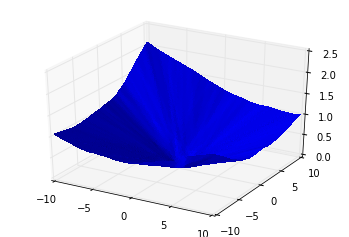

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(xy[:, 0], xy[:, 1], shallow_outs[:, 0], edgecolors="none", linewidth=0, shade=True, antialiased=False)
#ax.set_xlim((-1, 1))
#ax.set_ylim((-1, 1))

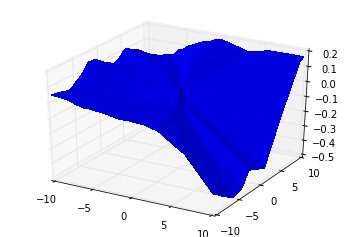

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(xy[:, 0], xy[:, 1], deep_outs[:, 0], edgecolors="none", linewidth=0, shade=True, antialiased=False)
#ax.set_xlim((-1, 1))
#ax.set_ylim((-1, 1))

### What about one in and one out?

Is that too trivial?

The above is not especially enlightening, and counting the linear regions in two dimensions might be tedious

In [12]:
tf.reset_default_graph()
grid_range = tf.linspace(-1.0, 1.0, 100000)

# X, Y = tf.meshgrid(grid_range, grid_range)
grid_inputs = tf.expand_dims(grid_range, 1)  # tf.concat(1, [tf.reshape(X, [-1, 1]), tf.reshape(Y, [-1, 1])])

shallow_net = get_fixed_param_net(grid_inputs, 2,  1, 2000, 'shallow')
deep_net    = get_fixed_param_net(grid_inputs, 5, 1, 2000, 'deep')
deeper_net  = get_fixed_param_net(grid_inputs, 10, 1, 2000, 'deeper')

shallow_net = tf.squeeze(shallow_net)
deep_net = tf.squeeze(deep_net)
deeper_net = tf.squeeze(deeper_net)

[ 666.33333333]
each layer: 666
estimated 1999 params
[-26.83279569  24.83279569]
each layer: 25
estimated 2026 params
[-16.50987834  15.13487834]
each layer: 15
estimated 1966 params


In [13]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    
    shallow_outs, deep_outs, deeper_outs, x = sess.run(
        [shallow_net, deep_net, deeper_net, grid_inputs])

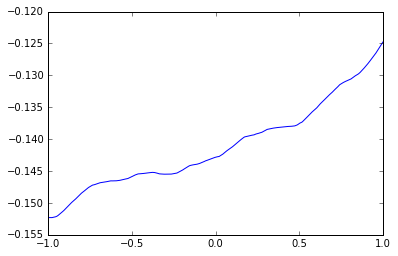

In [14]:
plt.plot(x, shallow_outs)

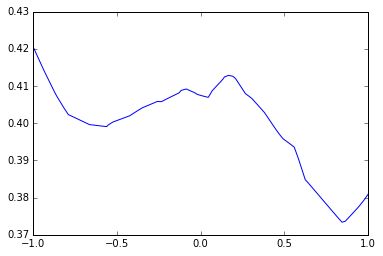

In [15]:
plt.plot(x, deep_outs)

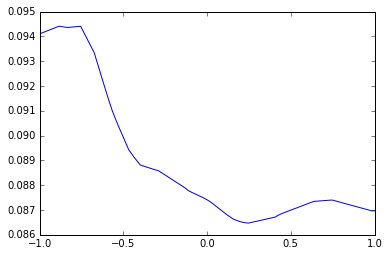

In [16]:
plt.plot(x, deeper_outs)

ok, let's try count them.

although still feel like 1d might be too simple

In [17]:
def count_linear_regions(data, tolerance=5e-7):
    """just count the number of times the gradient changes"""
    # can we do it without a python loop?
    if len(data.shape) == 2 and data.shape[1] != 1:
        raise ValueError('need 1d data')
    data = data.reshape(-1)
    diffs = data[1:] - data[:-1]
    # now we just need to count points when it changes
    # print(diffs)
    # sdiffs = diffs[:-1] - diffs[1:]
    # print(sdiffs)
    # plus 1, because there's always one
    return np.sum(~np.isclose(diffs[:-1], diffs[1:], atol=tolerance)) + 1

In [18]:
print('shallow : {}'.format(count_linear_regions(shallow_outs)))
print('deep    : {}'.format(count_linear_regions(deep_outs)))
print('deeper  : {}'.format(count_linear_regions(deeper_outs)))

shallow : 1
deep    : 18
deeper  : 1


In [19]:
# seems to change a lot, let's check an average
shallow_av, deep_av, deeper_av = 0, 0, 0
num_tests = 100
for i in range(num_tests):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())

        shallow_outs, deep_outs, deeper_outs, x = sess.run(
            [shallow_net, deep_net, deeper_net, grid_inputs])
        shallow_av += count_linear_regions(shallow_outs)
        deep_av += count_linear_regions(deep_outs)
        deeper_av += count_linear_regions(deeper_outs)
        print('\r{}'.format(i), end='')
print()
print('shallow: {}'.format(shallow_av / num_tests))
print('   deep: {}'.format(deep_av / num_tests))
print(' deeper: {}'.format(deeper_av / num_tests))

99
shallow: 1.0
   deep: 16.17
 deeper: 2.39


alright, let's do it for real

In [20]:
tf.reset_default_graph()
grid_range = tf.linspace(-10.0, 10.0, 1000000)
grid_inputs = tf.expand_dims(grid_range, 1)

nets = {i:  get_fixed_param_net(grid_inputs, i, 1, 500, scope='{}-layer'.format(i))
        for i in range(2, 11)}

[ 166.33333333]
each layer: 166
estimated 499 params
[-24.42766149  20.42766149]
each layer: 20
estimated 481 params
[-17.09495188  14.59495188]
each layer: 15
estimated 526 params
[-13.93573861  11.93573861]
each layer: 12
estimated 505 params
[-12.07837561  10.32837561]
each layer: 10
estimated 471 params
[-10.82197585   9.22197585]
each layer: 9
estimated 478 params
[-9.90036429  8.40036429]
each layer: 8
estimated 457 params
[-9.18753293  7.7589615 ]
each layer: 8
estimated 529 params
[-8.61515137  7.24015137]
each layer: 7
estimated 470 params


In [21]:
num_tests = 200
counts = [0 for _ in nets]
with tf.Session() as sess:
    for i in range(num_tests):
        sess.run(tf.initialize_all_variables())
        results = sess.run(
            [net_out for _, net_out in sorted(nets.items())])
        for j, result in enumerate(results):
            counts[j] += count_linear_regions(result)
        print('\r{}'.format(i), end='')
print()
for depth, count in zip(nets, counts):
    print('depth {}: {}'.format(depth, count/num_tests))

199
depth 2: 26303.77
depth 3: 86515.4
depth 4: 69509.855
depth 5: 52835.27
depth 6: 29003.44
depth 7: 17150.645
depth 8: 9549.035
depth 9: 8268.8
depth 10: 1052.95


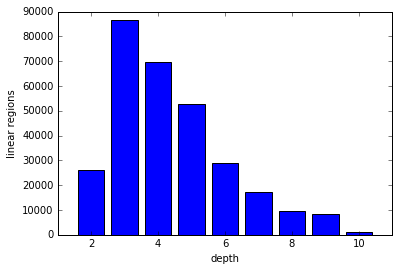

In [22]:
ind = np.array([depth for depth in nets])
width = 0.8

plt.bar(ind-width/2, np.array(counts)/num_tests, width)
plt.xlabel("depth")
plt.ylabel("linear regions")

## what if we train them

Let's train them on some toy data that needs a fair number of linear regions:

In [23]:
# let's use slightly fewer
tf.reset_default_graph()
grid_range = tf.linspace(-10.0, 10.0, 10000)
grid_inputs = tf.expand_dims(grid_range, 1)

nets = {i:  get_fixed_param_net(grid_inputs, i, 1, 500, scope='{}-layer'.format(i))
        for i in range(2, 11, 2)}

targets = tf.sin(grid_inputs)  # roughly 1.5 oscillations each way, so about 3 overall
loss_ops = [tf.reduce_mean(tf.squared_difference(net_out, targets))
            for _, net_out in sorted(nets.items())]
opt = tf.train.GradientDescentOptimizer(0.01)
train_ops = [opt.minimize(loss) for loss in loss_ops]
train_all = tf.group(*train_ops)

[ 166.33333333]
each layer: 166
estimated 499 params
[-17.09495188  14.59495188]
each layer: 15
estimated 526 params
[-12.07837561  10.32837561]
each layer: 10
estimated 471 params
[-9.90036429  8.40036429]
each layer: 8
estimated 457 params
[-8.61515137  7.24015137]
each layer: 7
estimated 470 params


In [24]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
num_epochs = 10000

losses = {key: [] for key in nets}
regions = {key: [] for key in nets}

for epoch in range(num_epochs):
    results = sess.run(loss_ops + [train_all])
    print('\r({}): {}'.format(epoch, ','.join([str(r) for r in results[:-1]])), end='')
    
    # also count the linear regions
    outputs = sess.run([net for _, net in nets.items()])
    
    for i, key in enumerate(sorted(nets)):
        losses[key].append(results[i])
        regions[key].append(count_linear_regions(outputs[i]))

(9999): 0.235716,0.0280709,0.00554909,0.0283386,0.0190934

Let's see how close they got, as well as how the linear regions and losses tracked

depth 2


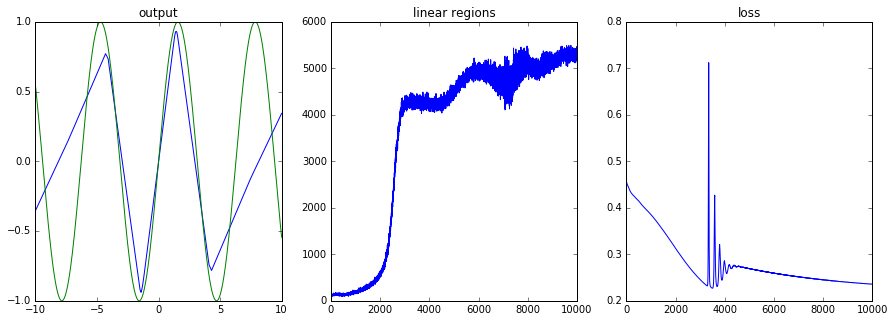

depth 4


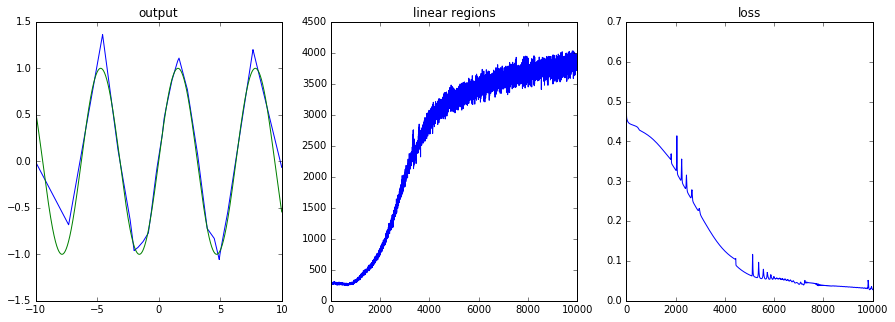

depth 6


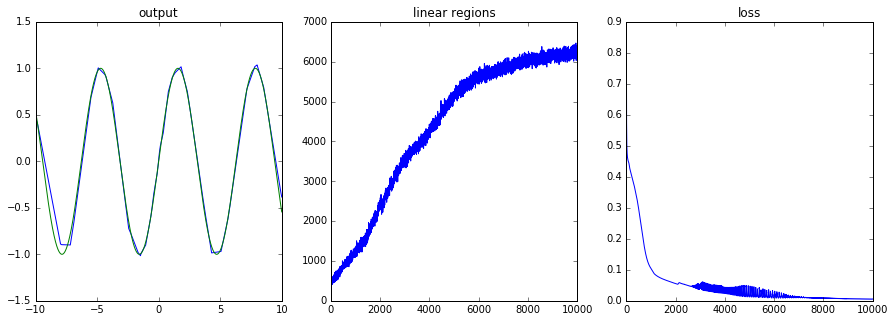

depth 8


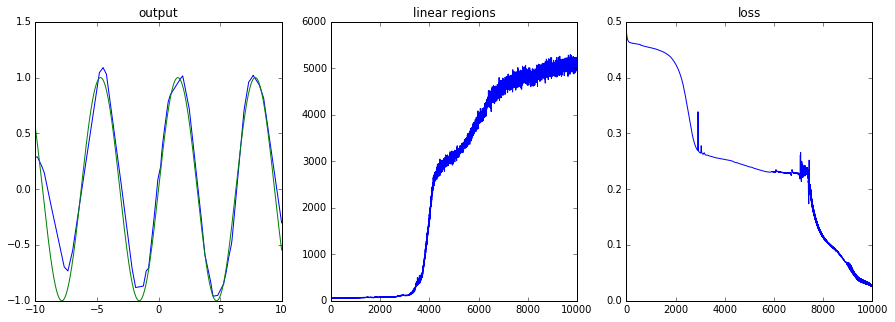

depth 10


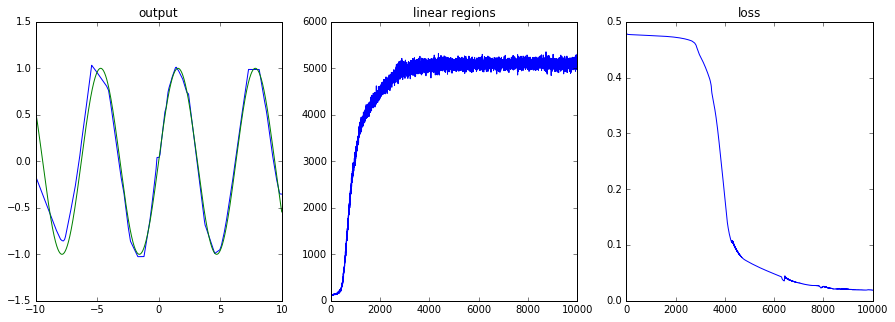

In [25]:
target_output, x = sess.run([targets, grid_inputs])
run_idx = np.arange(num_epochs)

for depth, output in sorted(nets.items()):
    print("depth {}".format(depth))
    net_out = sess.run(output)
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.title("output")
    plt.plot(x, net_out)
    plt.plot(x, target_output)
    
    plt.subplot(132)
    plt.title("linear regions")
    plt.plot(run_idx, regions[depth])
    
    plt.subplot(133)
    plt.title("loss")
    plt.plot(run_idx, losses[depth])
    plt.show()
    

Unsurprisingly, the net that finished with the highest number of linear regions had the lowest error at the end as well. There's some pretty unusual patterns, but they are all on the right track. Interesting;y the number of linear regions does increase with training to approximate a non-linear function. This suggests the following:
- the number of apparent linear regions at initialisation is not necessarily the number of linear regions the net is capable of. A key reason for this is simply that we test linear regions in a range, and there is a reasonable chance that many regions are outside the range. As the target function requires quite a few linear regions to model accurately, we would expect the regions to slide into the range we test during training. 
- all networks were capable of increasing the number of regions inside a given range during training. Whether this is splitting parallel/shadowed regions or moving them inside the range, the general shape of the linear region curve is pretty similar for all nets.
- all networks finished with a similar number of linear regions. Conclusions from this fact are:
    - if the target is bounded, the networks have a similar ability to shift linear regions into the bounds and use them for approximation
    - the method of counting linear regions isn't perfect
        - visual inspection appears to suggest that the 2 layer net has 6 linear regions (being generous), which doesn't seem a lot like 5,000. For the other nets it's harder to tell, but the results doo seem an order of magnitude off. However, looking at where they end up, the depth 8 network does appear to have the most nonlinearity in its output and it finishes the highest, so the measurements probably are at least useful relative to one another.